<h1 align="center">POC - Automatic Classification Of Textual Occurrences</h1>
<h3 align="center">Daniel Santos Pereira | Data & B.I Analyst | Machine Learning Analyst | MCP</h3>

In [1]:
# Setup
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# libraries
import pandas as pd
import numpy as np
import re

from nltk.corpus import stopwords
from unicodedata import normalize

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import  TfidfTransformer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# "error", "ignore", "always", "default", "module" or "once"
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Informations:

1.   The data for training, are occurrences of customers who were attended by the support team between the years 2018 and 2019
2.   The test data, are occurrences of customers who were attended by the support team in the year 2020

In [0]:
# Import training data with data between 2018 and 2019
df_training = pd.read_csv('sample_data/data_train.csv',
                          sep=';',
                          encoding='latin-1')

# Import for testing. These data are from the year 2020
df_test = pd.read_csv('sample_data/data_test.csv',
                      sep=';',
                      encoding='latin-1')

In [0]:
# rename columns
columnsName = ['OccurrenceNumber','Occurrence','Date','IdProcess','Process','IdSolicitation','Solicitation']
df_training.columns=columnsName

In [5]:
# show structure from dataframe
df_training.shape

(123080, 7)

In [6]:
# Checking the dataframe index
df_training.index

RangeIndex(start=0, stop=123080, step=1)

In [7]:
# Checking the data types
df_training.dtypes

OccurrenceNumber    object
Occurrence          object
Date                object
IdProcess            int64
Process             object
IdSolicitation       int64
Solicitation        object
dtype: object

In [8]:
# Checking the dataframe info
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123080 entries, 0 to 123079
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   OccurrenceNumber  123080 non-null  object
 1   Occurrence        123080 non-null  object
 2   Date              123080 non-null  object
 3   IdProcess         123080 non-null  int64 
 4   Process           123080 non-null  object
 5   IdSolicitation    123080 non-null  int64 
 6   Solicitation      123080 non-null  object
dtypes: int64(2), object(5)
memory usage: 6.6+ MB


In [9]:
# Checking null values
df_training.isna().sum()

OccurrenceNumber    0
Occurrence          0
Date                0
IdProcess           0
Process             0
IdSolicitation      0
Solicitation        0
dtype: int64

In [10]:
# Checking the dataframe structure 
df_training.head(2)

,OccurrenceNumber,Occurrence,Date,IdProcess,Process,IdSolicitation,Solicitation
0,00851624,Boa tarde!!Cliente solicita exclusão da cobert...,2018-05-29,2,ALTERAÇÕES,34,ALTERAÇÃO DE COBERTURA - INCLUSÃO/EXCLUSÃO DE ...
1,01259398,Cliente solicita a cópia de proposta de adesão...,2018-09-24,3,SOLICITAÇÃO DE SERVIÇOS,41,2ª VIA DA PROPOSTA DE ADESÃO


In [0]:
# Create of a new column to add the total character of each occurrence
df_training['CharacterQtd'] = df_training['Occurrence'].apply(len)

In [12]:
# Checks the maximum character values
df_training[['CharacterQtd']].max()

CharacterQtd    2298
dtype: int64

In [13]:
# Show data
df_training[df_training['CharacterQtd'] == 2298][['OccurrenceNumber','Process','Solicitation']].iloc[0]

OccurrenceNumber          02205000
Process                   COBRANÇA
Solicitation        MULTIPLICIDADE
Name: 54255, dtype: object

### Graph Showing The Quantity Of Character Per Process

In [0]:
# Data per Process
df_process = df_training[['Process','CharacterQtd']].drop_duplicates().groupby(
    ['Process','CharacterQtd']).head()

# Dataframe organization 
df_process = df_process.groupby(['Process']).sum().sort_values(
    by='CharacterQtd'
    ,ascending=False).reset_index()

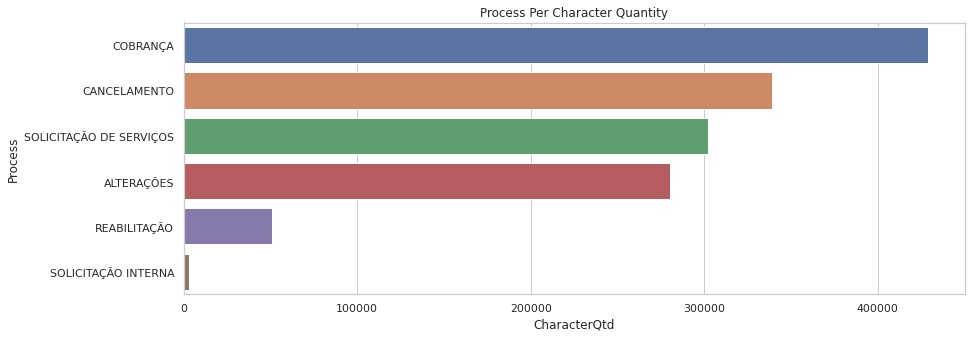

In [17]:
plt.figure(figsize=(14, 5))
sns.set(style="whitegrid")
ax_process = sns.barplot(x="CharacterQtd",
                 y="Process",
                 data=df_process)
ax_process.set_title('Process Per Character Quantity');

### Handling Text

In [0]:
# Function to perform data cleaning
def func_HandlingText(txt):
    
    listWords = ['boa','tarde','bom','dia','noite','cliente','apólice','é',
                     'pra','att','solicita','favor','yahoo','mail','br']
    
    txt = normalize('NFKD',
                    txt.lower()).encode('ASCII','ignore').decode('ASCII')
    
    # Remove accentuation from words
    handling_text = re.sub(r'[^\w\*]',' ',str(txt))
    
    # Remove numbers
    handling_text = list([num for num in handling_text
                          if not str.isnumeric(num)])
    
    # Join to re-form the string
    handling_text = ''.join(handling_text)
    
    # Remove multiple spaces
    handling_text = re.sub(r'\s+', ' ', str(handling_text), flags=re.I)
    
    # Remove all unique characters
    handling_text = re.sub(r'\s+[a-zA-Z]\s+',' ',str(handling_text))
    
    # Remove unique characters from the beginning
    handling_text = re.sub(r'\^[a-zA-Z]\s+', ' ', str(handling_text))
    
    # Remove other unnecessary words 
    handling_text = [lst for lst in handling_text.split()
                     if lst not in listWords]
    # Remove as stopwords
    handling_text = [palavra for palavra in handling_text
                     if palavra not in stopwords.words('portuguese')]
    
    return handling_text

In [0]:
# Creates word column with data already processed
df_training['Words'] = df_training['Occurrence'].apply(func_HandlingText)

In [19]:
# Checks returns
df_training['Words'].head(2)

0    [exclusao, cobertura, conjuge, informar, novo,...
1                    [copia, proposta, adesao, mpaulo]
Name: Words, dtype: object

### Process text
Creating a pipeline with the following steps: CountVectorizer (), TfidfTransformer (), MultinomialNB ()

In [0]:
pipeline = Pipeline([
                     ('cv', CountVectorizer(analyzer=func_HandlingText,
                           max_df=.6,
                           min_df=5,)),  # strings to token integer counts
                     ('tfidf', TfidfTransformer()),   # integer counts to weighted TF-IDF scores
                     ('classifier', MultinomialNB()) # train on TF-IDF vectors w/ Naive Bayes classifier
                     ])

Division of training and test data

In [0]:
# Division of training and test data
X = df_training['Occurrence']
y = df_training['IdProcess']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [22]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer=<function func_HandlingText at 0x7fb385952c80>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.6,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Evaluation

In [0]:
# Predictions arrays
predictions = pipeline.predict(X_test);

In [24]:
# Checking Confusion Matrix
print(confusion_matrix(y_test,predictions))

[[ 5814   336   316     0   969]
 [  494 10426    93     0   220]
 [  481   379  8352     0    90]
 [   38     9     3     0     1]
 [  519   170    75     0  8139]]


In [25]:
# Checking Classifications
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.79      0.78      0.79      7435
           2       0.92      0.93      0.92     11233
           3       0.94      0.90      0.92      9302
           4       0.00      0.00      0.00        51
           5       0.86      0.91      0.89      8903

    accuracy                           0.89     36924
   macro avg       0.70      0.70      0.70     36924
weighted avg       0.89      0.89      0.89     36924



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Prediction with Data Test

In [0]:
# Rename columns
df_test.columns=columnsName

# Remove columns
df_test.drop(columns=['Date', 'IdSolicitation', 'Solicitation'], inplace=True)

In [0]:
# Performing the Analysis on All Occurrence Descriptions
x_prediction = pipeline.predict(df_test['Occurrence'])

In [0]:
# Column creation with the prediction result
df_test = df_test.join(pd.DataFrame(x_prediction))

# Rename Column
df_test.rename(columns={0: 'PredictionResult'}, inplace=True)

# Drop Column Occurrence
df_test.drop('Occurrence', axis=1, inplace=True)

### Results Validations

In [0]:
# Add the "equal" column to compare the prediction result with the value of the IdProcess column
df_test['Equals'] = np.where((df_test['IdProcess'] == df_test['PredictionResult']) , 1, 0)

In [0]:
# Return total rows
total_rows = df_test.shape[0]
df_test['Total'] = 1

# Sums aggregated values
agreg = df_test.groupby(['Process']).agg(sum)

# Checking hit percentage
agreg["Hit"] = round((agreg['Equals'] * 100) / agreg['Total'],2)

# Checking Percentage of error
value_error = agreg['Total'] - agreg['Equals']
agreg['Error'] = round((value_error * 100) / agreg['Total'],2)

# Dataframe organization
agreg['Process'] = agreg.index

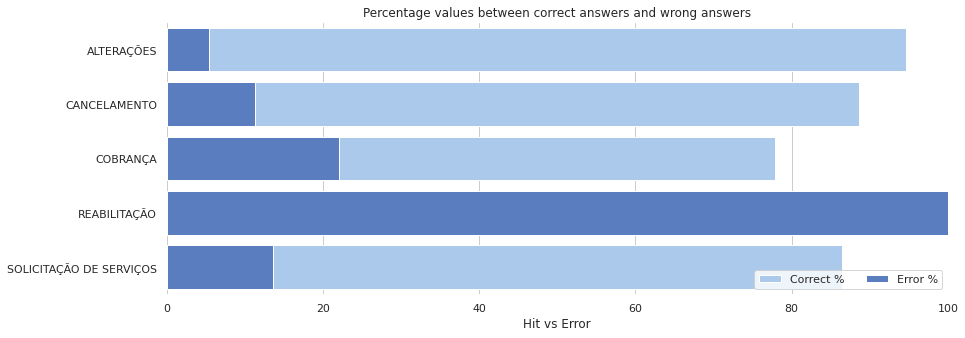

In [31]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 5))

# Plot the agreg to correct answers
sns.set_color_codes("pastel")
sns.barplot(x="Hit", y="Process", data=agreg,
            label="Correct %", color="b")

# Plot the agreg to wrong answers
sns.set_color_codes("muted")
sns.barplot(x="Error", y="Process", data=agreg,
            label="Error %", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Hit vs Error")
sns.despine(left=True, bottom=True)
ax.set_title('Percentage values between correct answers and wrong answers');